In [43]:
import librosa
import pandas as pd
import numpy as np

In [44]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True) # mount to google drive

Mounted at /content/gdrive


In [45]:
audio_files = pd.DataFrame(pd.read_excel("/content/gdrive/MyDrive/222 proj/data.xlsx")) # audio
audio_files

,file_name,assertiveness,enthusiasim,clairity,engagement
0,Aaron_Beverly.wav,8,6,9,9
1,b1.wav,3,3,5,2
2,b2.wav,6,7,5,7
3,champ.wav,9,10,9,10
4,harvard.wav,8,7,8,8
5,miss_teen.wav,6,6,2,4
6,obama_2020.wav,8,7,9,8
7,obama.wav,10,9,9,9
8,reporter.wav,7,5,3,4
9,socks.wav,4,4,2,3


In [46]:
def preprocess_data(file_path):
  audio, sr = librosa.load(file_path, sr=16000) # 16000 is recommended sample rate
  mfccs_scaled = np.mean(librosa.feature.mfcc(y=audio, sr = 16000, n_mfcc=25).T, axis=0)
  return mfccs_scaled

In [47]:
import tensorflow as tf
mfcc_features_list = [] # list of spectrograms
for file_name in audio_files["file_name"]:
  print(file_name)
  audio = preprocess_data("/content/gdrive/MyDrive/222 proj/audio_clips/" + file_name)
  mfcc_features_list.append(audio) # append spectrogram audio data to audios. After the loop, audios will have the audio information of all the files as a spectrograms in different rows
audio_files.insert(0, "mfccs", mfcc_features_list) # insert mfccs

Aaron_Beverly.wav
b1.wav
b2.wav
champ.wav
harvard.wav
miss_teen.wav
obama_2020.wav
obama.wav
reporter.wav
socks.wav
Susan_Lozier_TED.wav
toast.wav
trudeau.wav
Woman.wav
trimmed_speech1.wav
trimmed_speech2.wav
trimmed_speech3.wav
trimmed_speech4.wav
trimmed_speech5.wav
trimmed_speech6.wav


In [48]:
audio_files.head() # check what audio_files looks like

,mfccs,file_name,assertiveness,enthusiasim,clairity,engagement
0,"[-355.01233, 80.249466, -18.828096, 16.806034,...",Aaron_Beverly.wav,8,6,9,9
1,"[-176.20737, 65.394585, -16.727531, 17.33147, ...",b1.wav,3,3,5,2
2,"[-377.40625, 90.72757, 5.678156, 7.091702, -3....",b2.wav,6,7,5,7
3,"[-236.3935, 67.31595, -19.487085, 20.926512, -...",champ.wav,9,10,9,10
4,"[-306.0925, 125.22217, -57.953915, 22.362713, ...",harvard.wav,8,7,8,8


<Axes: xlabel='enthusiasim', ylabel='Count'>

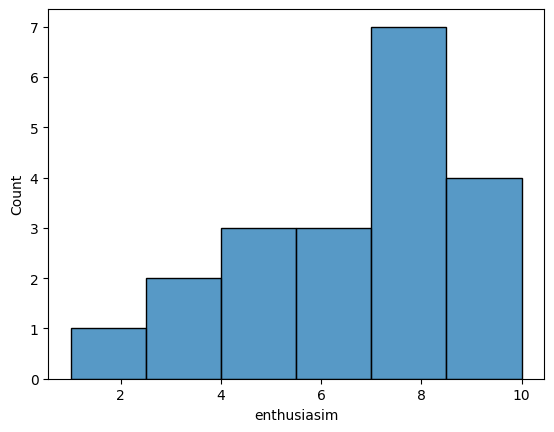

In [49]:
import seaborn
from scipy import stats

quality = "enthusiasim" # THIS IS WHERE TO CHOOSE WHICH QUALITY WE WANT TO TRAIN THE MODEL ON
seaborn.histplot(data=audio_files[quality])


In [50]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(audio_files['mfccs'], audio_files[quality], test_size=0.25, random_state=48) # split into 80% 20% training testing datasets


In [51]:
y_train

12     7
18     6
3     10
11    10
10     7
13     5
15     8
2      7
14     7
6      7
19     1
16     3
4      7
17    10
0      6
Name: enthusiasim, dtype: int64

In [52]:
from tensorflow.python.framework import ops
# convert training and testing data lists into np array
x_train = np.asarray(x_train)
x_test = np.asarray(x_test)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)
# convert to tensor
x_train = np.array([tensor for tensor in x_train])
x_test = np.array([tensor for tensor in x_test])

In [53]:
x_train

array([[-2.77636414e+02,  7.15413284e+01, -1.00358715e+01,
         1.79659519e+01, -7.97756863e+00, -7.03670216e+00,
        -1.06724072e+01, -1.24712009e+01, -1.40000458e+01,
        -3.77039742e+00, -6.07433414e+00, -1.34562886e+00,
        -6.26424837e+00, -4.14558142e-01, -1.02040415e+01,
        -1.22253215e+00, -5.75035620e+00, -9.02848184e-01,
        -5.78578329e+00, -2.70644331e+00, -7.88786697e+00,
        -2.83015108e+00, -7.65306282e+00, -6.23448038e+00,
        -4.98755884e+00],
       [-1.56140701e+02,  8.24230499e+01, -1.07907190e+01,
         1.74611626e+01, -2.14329376e+01, -1.81650677e+01,
        -1.15121937e+01, -1.70742054e+01, -1.69173965e+01,
        -3.92769933e+00, -1.32921619e+01, -1.86927855e+00,
        -1.06285219e+01, -2.89744878e+00, -1.15880728e+01,
        -5.89806271e+00, -8.52392197e+00, -3.34981012e+00,
        -9.91080570e+00, -4.82049912e-01, -7.90863943e+00,
        -4.55100012e+00, -6.74740648e+00, -4.71515036e+00,
        -7.42661428e+00],
    

In [54]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, MaxPooling1D

# create model
model = Sequential()
model.add(Dense(100, activation='relu'))

model.add(Dense(1, activation='relu'))


In [55]:
x_train

array([[-2.77636414e+02,  7.15413284e+01, -1.00358715e+01,
         1.79659519e+01, -7.97756863e+00, -7.03670216e+00,
        -1.06724072e+01, -1.24712009e+01, -1.40000458e+01,
        -3.77039742e+00, -6.07433414e+00, -1.34562886e+00,
        -6.26424837e+00, -4.14558142e-01, -1.02040415e+01,
        -1.22253215e+00, -5.75035620e+00, -9.02848184e-01,
        -5.78578329e+00, -2.70644331e+00, -7.88786697e+00,
        -2.83015108e+00, -7.65306282e+00, -6.23448038e+00,
        -4.98755884e+00],
       [-1.56140701e+02,  8.24230499e+01, -1.07907190e+01,
         1.74611626e+01, -2.14329376e+01, -1.81650677e+01,
        -1.15121937e+01, -1.70742054e+01, -1.69173965e+01,
        -3.92769933e+00, -1.32921619e+01, -1.86927855e+00,
        -1.06285219e+01, -2.89744878e+00, -1.15880728e+01,
        -5.89806271e+00, -8.52392197e+00, -3.34981012e+00,
        -9.91080570e+00, -4.82049912e-01, -7.90863943e+00,
        -4.55100012e+00, -6.74740648e+00, -4.71515036e+00,
        -7.42661428e+00],
    

In [56]:
model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mse'])

# train the model
history = model.fit(x_train, y_train, epochs = 100, validation_data=[x_test, y_test])

Epoch 1/100
1/1 [==============================] - 1s 981ms/step - loss: 579.1696 - mae: 23.2663 - mse: 579.1696 - val_loss: 402.4151 - val_mae: 18.8852 - val_mse: 402.4151
Epoch 2/100
1/1 [==============================] - 0s 53ms/step - loss: 373.0915 - mae: 18.5217 - mse: 373.0915 - val_loss: 237.2430 - val_mae: 14.3034 - val_mse: 237.2430
Epoch 3/100
1/1 [==============================] - 0s 34ms/step - loss: 215.1738 - mae: 13.8315 - mse: 215.1738 - val_loss: 119.2247 - val_mae: 9.8380 - val_mse: 119.2247
Epoch 4/100
1/1 [==============================] - 0s 34ms/step - loss: 105.2673 - mae: 9.2787 - mse: 105.2673 - val_loss: 46.3183 - val_mae: 5.5879 - val_mse: 46.3183
Epoch 5/100
1/1 [==============================] - 0s 35ms/step - loss: 40.4565 - mae: 5.1786 - mse: 40.4565 - val_loss: 12.7504 - val_mae: 2.5651 - val_mse: 12.7504
Epoch 6/100
1/1 [==============================] - 0s 35ms/step - loss: 14.8446 - mae: 3.3142 - mse: 14.8446 - val_loss: 7.9874 - val_mae: 2.7979 - va

In [64]:
y_pred = model.predict(x_test)
print(y_pred)

1/1 [==============================] - 0s 110ms/step
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [62]:
from sklearn.metrics import r2_score
print(r2_score(y_test, y_pred))

-6.877358490566038


In [63]:
for y in range(0, len(y_pred)):
  print("Actual Enthusiasm", y_test[y], "Predicted enthusiasm:", y_pred[y][0])

Actual Enthusiasm 3 Predicted enthusiasm: 0.0
Actual Enthusiasm 4 Predicted enthusiasm: 0.0
Actual Enthusiasm 6 Predicted enthusiasm: 0.0
Actual Enthusiasm 9 Predicted enthusiasm: 0.0
Actual Enthusiasm 5 Predicted enthusiasm: 0.0


In [60]:
from scipy.stats import spearmanr
coef, p = spearmanr(y_test, y_pred)
print(coef)

nan


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [23]:
!mkdir saved_models
model.save("saved_models/" + quality) # create ability to save model for any quality

In [24]:
!zip -r "saved_models.zip" "saved_models"

  adding: saved_models/ (stored 0%)
  adding: saved_models/enthusiasim/ (stored 0%)
  adding: saved_models/enthusiasim/keras_metadata.pb (deflated 83%)
  adding: saved_models/enthusiasim/fingerprint.pb (stored 0%)
  adding: saved_models/enthusiasim/saved_model.pb (deflated 85%)
  adding: saved_models/enthusiasim/assets/ (stored 0%)
  adding: saved_models/enthusiasim/variables/ (stored 0%)
  adding: saved_models/enthusiasim/variables/variables.index (deflated 59%)
  adding: saved_models/enthusiasim/variables/variables.data-00000-of-00001 (deflated 23%)


In [25]:
# after saving all different models...

In [26]:
def test_speech(file_name, characteristic):
  if characteristic not in ("assertiveness", "enthusiasm", "clarity", "engagement"):
    print("Error: test_speech called with bad characteristic. Please use one of the following: assertiveness, enthusiasm, clarity, engagement")
    return -1

  model = tf.keras.models.load_model('saved_models/' + quality) # load in saved model

  spectrogram = get_spectrogram("/content/gdrive/MyDrive/222 proj/audio_clips/" + file_name)
  spectrogram = spectrogram[0:15000] # cut to 30 seconds
  return model.predict(spectrogram) # return prediction